<a href="https://colab.research.google.com/github/XUideaList/Validating-Ampere-s-law-with-PINN/blob/main/Validating_Ampere's_law.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Verifying the validity of Ampere's law experimetally

# The part that exploits PINN is in development
I am uploading this for preparation purposes addition to the suggestion of the following idea: using PINN for interpolation involving Convolutions


The following code was inspired by the experiment originally designed by PASCO - Ampere's law. Here, we will be reinforcing the logic of the given experiment using various methods.

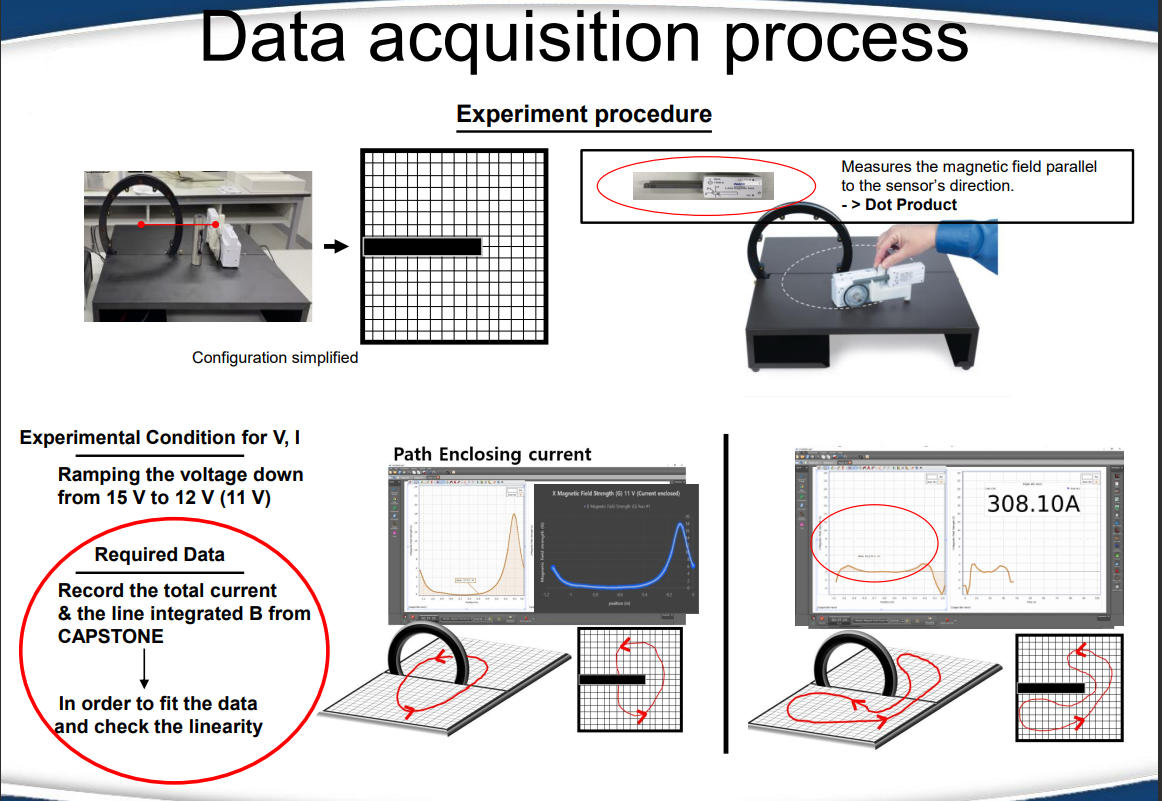

As shown in the figure above, The experiment trys to show the validity of Ampere's law by mounting a magnetic field sensor to a cart with the rotary sensor attached to its wheel. Using the CAPSTONE program, we are enable to access the magnetic field strength data with respect to the distance the cart moved. Here the experiment requires the path integrated field data for different paths, one with the path enclosing the coil and the other that doesn't. Eventually, we can check the validity of Ampere's law (In the integration version) by comparing with the acquired data.

However, such data are limited to the paths that the cart moved. The main point is that we should show that the consistency stands for an arbitrary path, which lacks reliability of our logic. Therefore I have constructed another method to verify Ampere's law within the configuration by involving the experimental data.

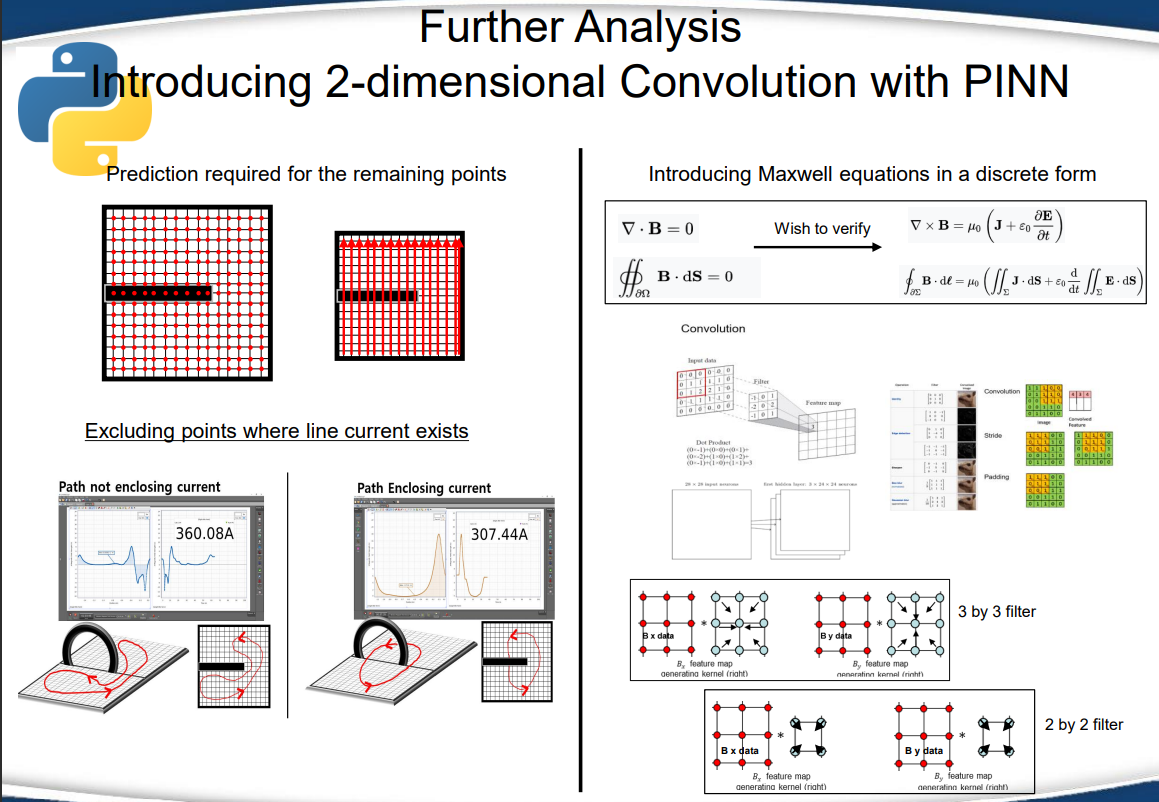

Unlike the original method, I will be using the differentiated version of Ampere's law. The data collecting procedure would also be modified as shown in the figure above. We would be collecting a 10 by 10 grid B field data which would be in a form of 2x10x10 tensor(or 10x10x2). After, 2 dimensional convolution will be introduced in order to evaluate the divergence of the magnetic field. For such process, I've managed to use the filters for evaluation of divergence using convolution as the filters shown in the figure above. (specifically, this code would be using a 2x2 filter)

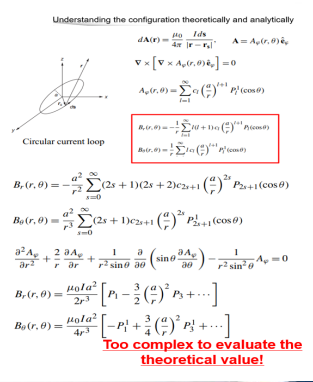

Note that the original field generated by the current loop of the experiment is complex to evaluate since it involves "**Associated Legendre polynomials**" in a form of "**infinite series**". So we would be first using a toy model using two current flowing line wires and then using experimental data for evaluation.

This also indicates that such method would be convenient to analyze fields that are complex to plot (just by using theoretical anlaysis.)

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import time

Mounted at /content/drive


# Implementing Confiuration
Note that for brevity, the toy field will using fields originated by multiple line currents.
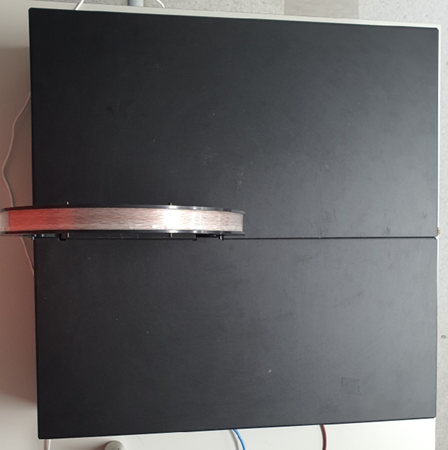


In [2]:
# Example Field
a = 0.10715 # m ,, radius perhaps..?
ring_w = 0.016 # m the width I assume.
W = 0.46 # m The side of the square plane
half_W = 0.23
slot_step = 10 #int(input(" How many data points collected in a n by n form:  "))
# This represents the number of data points that will be collected for a single row and the number of rows where the data will be collected.
d = W/slot_step # the interval between measured data points.
I_ampere = 400 # A, It's not the current itself that is actually yielding such value, but the product of the winding number and the actual current.
d1 = -W/10*2            #-0.0418*2      # the x-coordinate of the current line.
d2 =  0.15 -half_W/10   #-0.0209  # the x-coordinate of the other current line.

mu = 4*np.pi*10E-7 #H/m

print("\n the configuration has a form of", W,"*",W, " m\n with a current loop of width", ring_w
      , " m. \n and the radius in average as", a , " m. \n required data points in total would be ", int(slot_step**2)
      , ". \n So the width of the measuring points would be : ", d ," m"
      , "total current within the configuration: ", I_ampere, " A")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", DEVICE)


 the configuration has a form of 0.46 * 0.46  m
 with a current loop of width 0.016  m. 
 and the radius in average as 0.10715  m. 
 required data points in total would be  100 . 
 So the width of the measuring points would be :  0.046  m total current within the configuration:  400  A
Device:  cpu


Field Data Format: [1, vector component, x_pos, y_pos],which is [2,10,10]
 the batch size won't be necessary at this case


In [3]:
slot_num = 10 # Number of data points collected
interp_coeff = 6 # The number of interpolating data points between each data point

# WARNING: Due to the poisitions of the line currents listed below in curr_list, there are errors
# when the interp_coeff becomes a odd_number (the interpolating point overlaps the position of the current source)
# One can resolve such an error by adjusting the position of the current
# This was intended to assure no singular fields when particularly using even numbered interp_coeff-s.

magnify_num = interp_coeff+1 # the Magnifying constant: roughly ~ interpolated/ordinary in integer
interp_num = (slot_num-1)*magnify_num+1 # the total number of data points placed on one side of the square configuration.
# The total grid size would then be the square of: (slot_num-1)*interp_coeff + slot_num

slot_length = W/slot_num#0.418/slot_num
interp_length = slot_length/magnify_num


curr_list = [[d1,0,-I_ampere],[d2,0,I_ampere]]

print("The number of data points to be interpolated between each grid data: %d"%interp_coeff)

The number of data points to be interpolated between each grid data: 6


Defining the functions for field generation

In [4]:
def coord_maker(x_i,x_f, y_i,y_f, d_x, d_y, option = 0): # d_x, d_y is the interval between two data points for each the horizontal and vertical axis.
  # returns an output tnesor with a form of [2, N_x, N_y]
  x_list = np.arange(x_i, x_f, d_x)
  y_list = np.arange(y_i, y_f, d_y)

#  n_x, n_y = np.size(x_list), np.size(y_list)
  grid_x, grid_y = np.meshgrid(x_list, y_list)

  if(option):
    return np.asarray([grid_x, grid_y]), grid_x, grid_y
  else:
    return np.asarray([grid_x,grid_y])


def field_maker(coordinates, current_list):  # current_pos -> [current_num] -> [[x,y],[x2,y2],...]
# I/r
  Bx, By = [],[]
  for idx_r1 in range(np.shape(coordinates)[1]):
    for idx_r2 in range(np.shape(coordinates)[2]):
      field_x, field_y = 0,0
      for idx_curr in range(len(current_list)):
        r_x = coordinates[0][idx_r1][idx_r2]-current_list[idx_curr][0]
        r_y = coordinates[1][idx_r1][idx_r2]-current_list[idx_curr][1]
        r_square = r_x**2+r_y**2

        field_x += -mu/(2*np.pi*r_square) * r_y * current_list[idx_curr][2]
        field_y += +mu/(2*np.pi*r_square) * r_x * current_list[idx_curr][2]

      Bx.append(field_x)
      By.append(field_y)

  Bx = np.reshape(np.asarray(Bx), (np.shape(coordinates)[1],np.shape(coordinates)[2]))
  By = np.reshape(np.asarray(By), (np.shape(coordinates)[1],np.shape(coordinates)[2]))

  Bx_tensor = torch.tensor(Bx, dtype = torch.float32)
  By_tensor = torch.tensor(By, dtype = torch.float32)
  B_total = ((torch.stack([Bx_tensor,By_tensor])).unsqueeze(0)).to(DEVICE)
  return B_total

#Functions for Plots

In [5]:
from PIL import Image

In [6]:
def current_pos_plot(current_list):
  # position of the current lines
  pos_curr, neg_curr = [], []
  for curr_elem in current_list:
    if(curr_elem[-1]>=0):
      pos_curr.append(curr_elem)
    if(curr_elem[-1]<0):
      neg_curr.append(curr_elem)

  for pos_curr_elem in pos_curr:
    if(pos_curr_elem == pos_curr[-1]):
      plt.scatter(pos_curr_elem[0], pos_curr_elem[1], color="red", s= 6, label="outcoming current")
    else:
      plt.scatter(pos_curr_elem[0], pos_curr_elem[1], color="red", s= 6)

  for neg_curr_elem in neg_curr:
    if(neg_curr_elem == neg_curr[-1]):
      plt.scatter(neg_curr_elem[0], neg_curr_elem[1], color="blue", s= 6, label = "ingoing current")
    else:
      plt.scatter(neg_curr_elem[0], neg_curr_elem[1], color="blue", s= 6)

In [7]:
def interpolated_scale_plot(vector_field, input_coords, coord_X, coord_Y, plot_name = "Title", mag_option=magnify_num): # interp length and other variables are defined via magnify_num.
#if mag_option changes, the plot isn't what we have anticipated. Revise it if you have enough time

  if isinstance(vector_field, torch.Tensor):
    vector_field = vector_field.detach().cpu().numpy()

 # Create the figure and axes
  fig, ax = plt.subplots()

  # plotting the space
  for index_pl1 in range(input_coords.shape[1]): # Or just use coord_config itself for the range
    for index_pl2 in range(input_coords.shape[2]):
      plt.scatter(input_coords[0][index_pl1][index_pl2],input_coords[1][index_pl1][index_pl2], color='orange', s=5)
  plt.scatter(input_coords[0][0][0],input_coords[1][0][0], color='orange', s=1, label='Training Points')

  # position of the current lines
  current_pos_plot(curr_list)
  # Plot the vector field
  scale=0.5
  #ax.quiver(X, Y, B_sh, B_sv)
  ax.quiver(coord_X, coord_Y, vector_field[0,0,:,:], vector_field[0,1,:,:], label='B-field')

  # Set plot title and labels
  ax.set_title("Interpolated field")
  ax.set_xlabel("X")
  ax.set_ylabel("Y")

  # Set aspect ratio to 'equal'
  ax.set_aspect('equal')

  plt.grid('on')
  plt.xlabel('Horizontal (m)')
  plt.ylabel('Vertical (m)')

  # Plotting the interpolated points
  if(mag_option>1):
    ax.set_title("B-field configuration with magnification: %d"%mag_option)
    mag_coord = coord_maker((-interp_length*mag_option*2), (interp_length*mag_option*7+interp_length-err)
                                                          , (interp_length*mag_option*4+half_W/10),(-half_W/10-interp_length*mag_option*4-interp_length+err)
                                                          , interp_length, -interp_length)
    for index_pl3 in range(mag_coord.shape[1]):
      for index_pl4 in range(mag_coord.shape[2]):
        plt.scatter(mag_coord[0][index_pl3][index_pl4],mag_coord[1][index_pl3][index_pl4], color='green', s=0.5)
    plt.scatter(mag_coord[0][0][0],mag_coord[1][0][0], color='green', s=0.5, label='Divergence Evaluating Points')

  plt.legend(loc=1, fontsize=6)
#  plt.show()

In [8]:
def field_plot(vector_field, coords, coord_X, coord_Y, training_option=1 ,eval_option=0, plot_name = "Title"): # blue print, result
  # Create the figure and axes
  fig, ax = plt.subplots()
  plt_mag = int((coords.shape[1]-1)/(slot_num-1))

  if isinstance(vector_field, torch.Tensor):
    vector_field = vector_field.detach().cpu().numpy()

  # position of the current lines
  current_pos_plot(curr_list)

  # plotting the space
  if(eval_option):
    for index_pl3 in range(coords.shape[1]):
      for index_pl4 in range(coords.shape[2]):
        plt.scatter(coords[0][index_pl3][index_pl4],coords[1][index_pl3][index_pl4], color='green', s=0.5)
    plt.scatter(coords[0][0][0],coords[1][0][0], color='green', s=0.5, label='Divergence Evaluating Points')

  if(training_option):
    for index_pl1 in range(slot_num): # Or just use coord_config itself for the range
      for index_pl2 in range(slot_num):
        plt.scatter(coords[0][index_pl1*plt_mag][index_pl2*plt_mag],coords[1][index_pl1*plt_mag][index_pl2*plt_mag], color='orange', s=5)
    plt.scatter(coords[0][0][0],coords[1][0][0], color='orange', s=1, label='Training Points')

  # Plot the vector field
  scale=0.5
  #ax.quiver(X, Y, B_sh, B_sv)
  ax.quiver(coord_X, coord_Y, vector_field[0,0,:,:], vector_field[0,1,:,:], label='B-field') # Note that the toy data is stored in a form of 10x10x2 tensor

  # Set plot title and labels
  ax.set_title(plot_name+", Magnification:%d"%magnify_num)
  ax.set_xlabel("X")
  ax.set_ylabel("Y")

  # Set aspect ratio to 'equal'
  ax.set_aspect('equal')

  plt.grid('on')
  plt.xlabel('Horizontal (m)')
  plt.ylabel('Vertical (m)')

  plt.legend(loc=1, fontsize=6)
#  plt.show()

In [9]:
err = 0.0001 # For even number magnifying coefficients, there is an error for the number of the interpolated points.
# So I added a small number.

#Simple Situation. The code within this section is just showing how I managed to creat a toy field for the input.
coord_config, X, Y = coord_maker(-slot_length*2, slot_length*8, (slot_length*4+half_W/10), (-half_W/10-slot_length*5), slot_length, -slot_length,1)
fixed_field = field_maker(coord_config, curr_list)

interp_config, XX, YY = coord_maker((-interp_length*magnify_num*2), (interp_length*magnify_num*7+interp_length-err)
                                                          , (interp_length*magnify_num*4+half_W/10),(-half_W/10-interp_length*magnify_num*4-interp_length+err)
                                                          , interp_length, -interp_length, magnify_num)
true_field = field_maker(interp_config, curr_list)

In [10]:
# Obtained coordinates and its structure
fixed_Datapoint = np.asarray([X,Y])
interpolated_Datapoint = np.asarray([XX, YY])
# the collected field is assumed to be ->  fixed_field, having the same data shape with the prior coordinates

# This is just for plotting
fixed_plot=[coord_config[0],coord_config[1]]
interp_plot = [interp_config[0], interp_config[1]]

print("\nshape of the fixed_plot", np.shape(fixed_plot), "\n")
print("Shape of the input field",np.shape(fixed_field), "\n")
print("Shape of the fixed points",np.shape(fixed_Datapoint), "\n")
print("Shape of the interpolated plot",np.shape(interpolated_Datapoint))

# Interpolated plots, the data points are numpy arrays while the generated field / output of the model are torch.tensors.


shape of the fixed_plot (2, 10, 10) 

Shape of the input field torch.Size([1, 2, 10, 10]) 

Shape of the fixed points (2, 10, 10) 

Shape of the interpolated plot (2, 64, 64)


# True Field

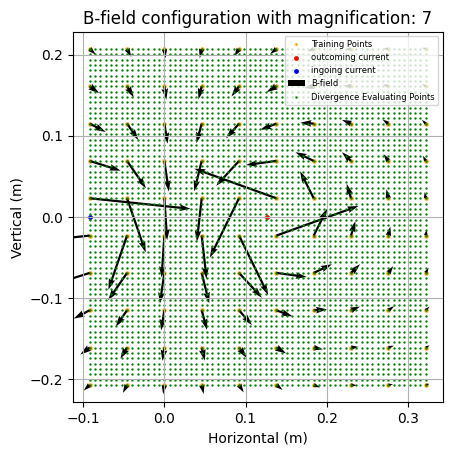

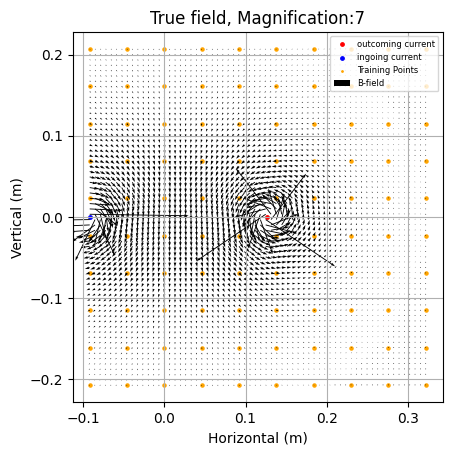

In [11]:
# Plotting the input field
#field_plot(fixed_field, coord_config,X,Y,0,0)

# Plotting the input field with training points
#field_plot(fixed_field, coord_config,X,Y,1,0)

# Plotting the input field with both training points and divergence evaluating points
interpolated_scale_plot(fixed_field, coord_config,  X, Y, "Input Status-magnify_number: %d"%magnify_num)


# Plotting the resulted field.
#field_plot(true_field, interp_config, XX, YY, 0, 0)
# Plotting the resulted field with training points
field_plot(true_field, interp_config, XX, YY, 1, 0, "True field")
# Plotting the resulted field with both training points and divergence evaluating points
#field_plot(true_field, interp_config, XX, YY, 1, 1)

plt.show()

With actual trials, it seems that plotting the eval points should be implemented only when plotting the input relation

In [12]:
# fields we have obtained:
field_list = [fixed_field, true_field]

# Convolution section for Evaluation indices

We could think of using different strides and different sizes of kernels to obtain different divergence maps and curl maps

Involving Physics for the kernels

* Exploiting the parity symmetry with respect to the plane of the configuration, the divergence theorem is held if it is valid on the plane of configuration. Remind this and consider the kernels to evaluate the divergence of the fields.

In [13]:
# Defining Kernels to compute derivatives of the vector field. It is a tedious process.

print("interpolating unit length: %.4f (m)"%interp_length)
dia = np.sqrt(1/2)*interp_length
pent = np.sqrt(1/5)*interp_length

# Divergence Section
div_kernel_v=[[dia,1,dia],   [0,0,0],   [-dia,-1,-dia]]
div_kernel_h=[[-dia,0,dia],  [-1,0,1],    [-dia,0,dia]]

div_kernel_vv = [[dia, 2*pent, 1, 2*pent, dia],   [pent, 0, 0, 0, pent], [ 0,0,0,0,0]
                 , [-pent, 0, 0, 0, -pent], [-dia, -2*pent, -1, -2*pent, -dia]]
div_kernel_hh = [[-dia, -pent, 0, pent, dia], [-2*pent, 0, 0, 0, 2*pent], [-1,0,0,0,1]
                 , [-2*pent, 0, 0, 0, 2*pent], [-dia, -pent, 0, pent, dia]]

div_kernel_vvv = [[dia, 2*pent, 1, 2*pent, dia],   [pent, dia, 1, dia, pent],  [0,0,0,0,0]
                  ,  [-pent, -dia, -1, -dia, -pent], [-dia, -2*pent, -1, -2*pent, -dia]]
div_kernel_hhh = [[-dia, -pent, 0, pent, dia],   [-2*pent, -dia, 0, dia, 2*pent],  [-1,-1,0,1,1]
                  , [-2*pent, -dia, 0, dia, 2*pent], [-dia, -pent, 0, pent, dia]]

div_shell_v = [[0, 0, 0, 0, 0], [0, dia, 1, dia, 0], [0,0,0,0,0], [0, -dia, -1, -dia, 0], [0, 0, 0, 0, 0]]
div_shell_h = [[0, 0, 0, 0, 0],  [0, -dia, 0, dia, 0],  [0,-1,0,1,0], [0, -dia, 0, dia, 0],  [0, 0, 0, 0, 0]]

div_kernel_3 = ((torch.tensor([div_kernel_h,div_kernel_v], dtype=torch.float32)).unsqueeze(0)).to(DEVICE)
shell_div_5  = ((torch.tensor([div_shell_h, div_shell_v], dtype=torch.float32)).unsqueeze(0)).to(DEVICE) # Padding is essential when using this filter
div_kernel_5 = ((torch.tensor([div_kernel_hh, div_kernel_vv], dtype=torch.float32)).unsqueeze(0)).to(DEVICE)
full_div_kernel_5 = ((torch.tensor([div_kernel_hhh, div_kernel_vvv], dtype=torch.float32)).unsqueeze(0)).to(DEVICE)

# Curl Section
curl_kernel_h = [[-dia, -1, -dia], [0,0,0],  [dia, 1, dia]]
curl_kernel_v = [[-dia, 0, dia], [-1,0,1], [-dia, 0, dia]]

curl_kernel_hh = [[-dia,-1,-1,-1,-dia],  [0,0,0,0,0], [0,0,0,0,0], [0,0,0,0,0], [dia,1,1,1,dia]]
curl_kernel_vv = [[-dia,0,0,0,dia], [-1,0,0,0,1],  [-1,0,0,0,1], [-1,0,0,0,1], [-dia,0,0,0,dia]]

curl_kernel_hhh = [[-dia,-1,-1,-1,-dia],  [0,-dia,-1,-dia,0],  [0,0,0,0,0]
                   , [0,dia,1,dia,0],  [dia,1,1,1,dia]]
curl_kernel_vvv = [[-dia,0,0,0,dia], [-1,-dia,0,dia,1],  [-1,-1,0,1,1]
                   , [-1,-dia,0,dia,1], [-dia,0,0,0,dia]]

curl_shell_h = [[0,0,0,0,0], [0,-dia,-1,-dia,0], [0,0,0,0,0], [0,dia,1,dia,0], [0,0,0,0,0]]
curl_shell_v = [[0,0,0,0,0],  [0,-dia,0,dia,0],  [0,-1,0,1,0], [0,-dia,0,dia,0], [0,0,0,0,0]]

curl_kernel_3 = ((torch.tensor([curl_kernel_h, curl_kernel_v], dtype=torch.float32)).unsqueeze(0)).to(DEVICE)
shell_curl_5 = ((torch.tensor([curl_shell_h, curl_shell_v], dtype=torch.float32)).unsqueeze(0)).to(DEVICE) # Padding is essential when using this filter
curl_kernel_5 = ((torch.tensor([curl_kernel_hh, curl_kernel_vv], dtype=torch.float32)).unsqueeze(0)).to(DEVICE)
full_curl_kernel_5 = ((torch.tensor([curl_kernel_hh, curl_kernel_vv], dtype=torch.float32)).unsqueeze(0)).to(DEVICE)

#div_kernels_tensor = [torch.tensor(kernel) for kernel in div_kernels]
#curl_kernels_tensor = [torch.tensor(kernel) for kernel in curl_kernels]

interpolating unit length: 0.0066 (m)


#Plotting and defining field_derivatives and its errors -> 에폭 타이틀에 넣을 수 있게 조치 바람.

Defining Convolution and Convolution layers for in/output vector fields

In [14]:
def div_err(div_map): # div_map -> (1,interp_num, interp_num) shaped tensor denoting the divergence of the field.
  grid_number = div_map.numel()
  divergence_error = torch.mean(torch.sqrt(div_map**2)) # weighted by squaring the divergence so that large errors contribute more.
  # May have to remove the squaring operation since it may converge to a trivial solution.
  return divergence_error

def curl_sum(curl_map):
  pos_idx, neg_idx = curl_map > 0, curl_map < 0
  pos_curl, neg_curl = torch.sum(curl_map[pos_idx]), torch.sum(curl_map[neg_idx])
  sum_pos, neg_pos = torch.sum(pos_curl), torch.sum(neg_curl)
  return sum_pos, neg_pos

# Defining a layer to evaluate the Divergence/Curl of the in/output field is done in the following sections describing NN models.
# The input for this layer will be the predicted field. (Or the true field depending on occasions)

# Outside the model just for clarification.
def vector_field_conv(input_field, diff_kernel):
  #print(input_field.dtype, diff_kernel.dtype)
  convoluted_field = F.conv2d(input_field, weight=diff_kernel,stride=1, padding=0)#, groups=input_field.shape[0])
  return convoluted_field

The convolution process itself doesn't take much time even for fields with magnfiy_num=7

Plotting Divergence error maps and Curl maps


Input divergence error: 0.0035006
Total divergence error: 0.0004109
Perimeter of the current-enclosing path: %.3f (m) 0.05257142857142857
Max_curl value:  tensor(0.4475)
With CurlMap: Permeability times outgoing current: 1.845, ingoing current: -0.688
Mu_0 * Current:  0.005026548245743669


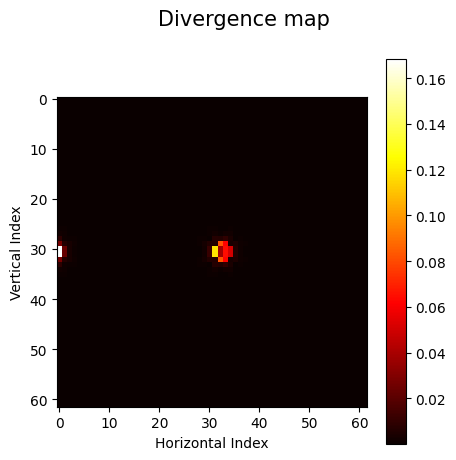

<Figure size 1920x1440 with 0 Axes>

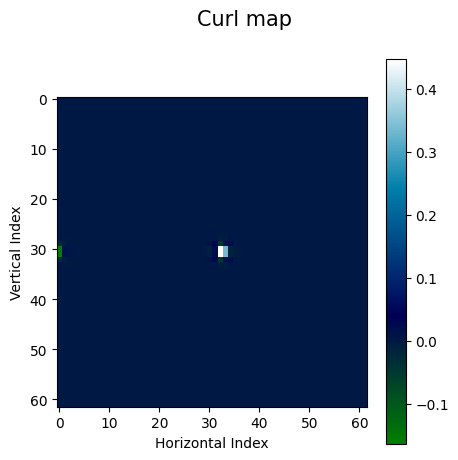

<Figure size 1920x1440 with 0 Axes>

In [15]:
def portable_heatmap(map_data, plot_name = "map", c_option="hot", show_option=0):
  map_dist = map_data.squeeze().detach().cpu().numpy() # (1, 1, N, N) -> (N, N)

  fig = plt.figure(figsize=(5,5))
  ax = fig.add_subplot(111)
  fig.suptitle(plot_name, fontsize = 15)

  plt.imshow(map_dist, cmap = c_option)
  plt.colorbar()
  #plt.title(plot_name)
  plt.xlabel("Horizontal Index")
  plt.ylabel("Vertical Index")

  if(show_option):
    plt.figure(dpi=300)
    plt.show()


testing_div, testing_curl = torch.sqrt(vector_field_conv(true_field, div_kernel_3)**2), vector_field_conv(true_field, curl_kernel_3)
input_div, input_curl = torch.sqrt(vector_field_conv(fixed_field, div_kernel_3)**2), vector_field_conv(fixed_field, curl_kernel_3)

#portable_heatmap(input_div, "Input divergence map", "hot",1)
#portable_heatmap(input_curl, "Input curl map", "ocean",1)

print("Input divergence error: %.7f"%div_err(input_div))

out_curr, in_curr = curl_sum(testing_curl)
unit_interp_area = interp_length**2

print("Total divergence error: %.7f"%div_err(testing_div))
print("Perimeter of the current-enclosing path: %.3f (m)", 8*interp_length)

print("Max_curl value: ", torch.max(testing_curl))
print("With CurlMap: Permeability times outgoing current: %.3f, ingoing current: %.3f"%(out_curr,in_curr))
print("Mu_0 * Current: ",mu*I_ampere)

portable_heatmap(testing_div, "Divergence map","hot",1)
portable_heatmap(testing_curl, "Curl map", "ocean",1)


#Defining a function to generate GIFs

In [16]:
from PIL import Image

def save_gif_PIL(outfile, files, fps=5, loop=0):  # call the function after adding a sseries of image composing the GIF.
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

#Designing our NN model

In [17]:
# Extracting points with tensor inputs.
def extract_error(pred_tensor, training_tensor, magnify_coeff=magnify_num, log_option = 0):
    mse_x = mse_y = 0
    check_list = [[], []]

    # comparing_tensor의 크기를 가져오기
    height, width = training_tensor.shape[2:4]
    for coord_x in range(height):
        for coord_y in range(width):
            # Extract values
            pred_value_x = pred_tensor[0, 0, coord_x * magnify_coeff, coord_y * magnify_coeff]
            pred_value_y = pred_tensor[0, 1, coord_x * magnify_coeff, coord_y * magnify_coeff]
            comparing_value_x = training_tensor[0, 0, coord_x, coord_y]
            comparing_value_y = training_tensor[0, 1, coord_x, coord_y]

            # Evaluate the MSE for training points
            mse_x += (comparing_value_x - pred_value_x) ** 2
            mse_y += (comparing_value_y - pred_value_y) ** 2

            # Append MSE to check_list for accession to the error log
            check_list[0].append(mse_x.item())  # tensor -> scalar
            check_list[1].append(mse_y.item())

    if(log_option):
      return torch.mean(mse_x+mse_y), check_list  # return it into scalar
    else:
      return torch.mean(mse_x+mse_y)

class Vectorfield_conv(nn.Module):
  def __init__(self, diff_kernel): # diff_kernel form: (torch.tensor([diff_kernel_x,diff_kernel_y]))
    super(Vectorfield_conv, self).__init__()
    self.kernel = diff_kernel # (1, 2, W_x, W_y) form kernel -> 2 input Channels(x,y comp of the vector field), 1 output (divergence, curl)
    self.conv = nn.Conv2d(in_channels=2, out_channels=1  # In : 2*interp_num*interp_num // Out: 1*m*m
                          ,kernel_size =(self.kernel.shape[2], self.kernel.shape[3])
                          ,stride = 1 ,padding = 0 # kernel size: m -> 2*(interp_num-m+1)*(interp_num-m+1)
                          ,bias=False)

    with torch.no_grad():
      self.conv.weight = nn.Parameter(self.kernel)

  def forward(self, x):
    x = self.conv(x)
    return x

# Checking the Error for ficed points when a zero field is fed.
test_zero_field = (torch.zeros(1,2,interp_num,interp_num)).to(DEVICE)
extract_example, extract_example_list = extract_error(test_zero_field, fixed_field, magnify_num, 1)
print(extract_example)

div_map_3_gen = Vectorfield_conv(div_kernel_3).to(DEVICE)
curl_map_3_gen = Vectorfield_conv(curl_kernel_3).to(DEVICE)

tensor(0.0097)


In [18]:
# 2-1. CNN Model. Took the structure of SRCNN into account.
class B_FieldInterpolator_Mk1(nn.Module):
    def __init__(self, input_size, output_size): # Feed the field in the first place
        super(B_FieldInterpolator_Mk1, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3, stride=1, padding='same')
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding='same')
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding='same')

        self.conv4 = nn.Conv2d(128,64, kernel_size=3, padding='same')
        self.conv5 = nn.Conv2d(64,32, kernel_size=3, padding='same')
        self.conv6 = nn.Conv2d(32,2, kernel_size=3, padding='same')

        pooled_size = input_size // 4  # Adjust based on pooling layers
        self.fc1 = nn.Linear(128 * pooled_size * pooled_size, 2 * output_size * output_size)
        self.fc2 = nn.Linear(2 * output_size * output_size, 2 * output_size * output_size)

        # Div Kernel
        # Curl Kernel

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(-1, 2, interp_num, interp_num)  # Reshape to (B, C, H, W)
        return x

# 3. Model Creation
model_Mk1 = B_FieldInterpolator_Mk1(input_size=slot_num, output_size=interp_num).to(DEVICE)

In [19]:
# 2-2. CNN Model.
class B_FieldInterpolator_Mk2(nn.Module):
    def __init__(self, input_size, output_size): # Feed the field in the first place
        super(B_FieldInterpolator_Mk2, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3, stride=1, padding='same')
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding='same')
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding='same')
      # Div Kernel
      # Curl Kernel

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(-1, 2, interp_num, interp_num)  # Reshape to (B, C, H, W)
        return x

# 3. Model Creation
model_Mk2 = B_FieldInterpolator_Mk2(input_size=slot_num, output_size=interp_num).to(DEVICE)

In [20]:
# 2-3 CNN model

class B_FieldInterpolator_Mk3(nn.Module):
  def __init__(self, input_size, output_size):
# Increasing the Kernel size for a certain layer would involve broader tendencies.
    super(B_FieldInterpolator_Mk3, self).__init__()
    self.conv1 = nn.Conv2d(2, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(64, 2, kernel_size=3, padding=1)
    self.upsample = nn.Upsample(size = (output_size,output_size)
                               ,mode='bilinear', align_corners=True)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.upsample(x)
    x = self.conv3(x)
    return x

# Example usage
model_Mk3 = B_FieldInterpolator_Mk3(slot_num, interp_num).to(DEVICE)

# Training Procedure & Resulted output

Fixed_data error: 0.12472170, Physics error: 0.00163051 in total 0.12472170 for episode : 0 


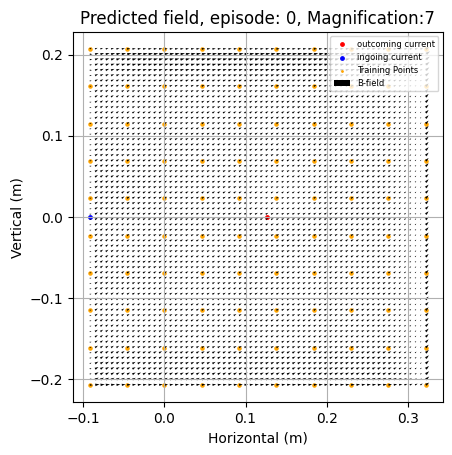

Fixed_data error: 0.00422438, Physics error: 0.00140557 in total 0.00422438 for episode : 50 
Fixed_data error: 0.00145098, Physics error: 0.00155732 in total 0.00145098 for episode : 100 
Fixed_data error: 0.00078364, Physics error: 0.00152026 in total 0.00078364 for episode : 150 
Fixed_data error: 0.00051908, Physics error: 0.00139175 in total 0.00051908 for episode : 200 
Fixed_data error: 0.00035113, Physics error: 0.00133037 in total 0.00035113 for episode : 250 
Fixed_data error: 0.00023177, Physics error: 0.00131164 in total 0.00023177 for episode : 300 
Fixed_data error: 0.00015073, Physics error: 0.00129888 in total 0.00015073 for episode : 350 
Fixed_data error: 0.00009971, Physics error: 0.00128106 in total 0.00009971 for episode : 400 
Fixed_data error: 0.00006854, Physics error: 0.00126901 in total 0.00006854 for episode : 450 
Fixed_data error: 0.00004938, Physics error: 0.00125824 in total 0.00004938 for episode : 500 
Fixed_data error: 0.00003671, Physics error: 0.0012

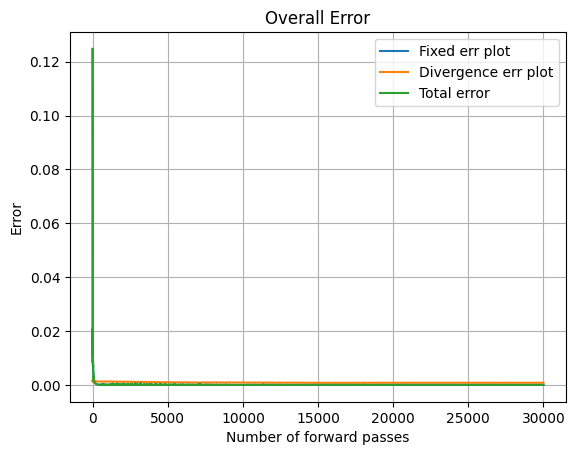

In [21]:
%matplotlib inline
model_list = [model_Mk1, model_Mk2, model_Mk3]
model = model_list[2]

torch.manual_seed(1024)
episodes = 20000 # Total number of interpolations.
num_plots = 400 # Number of plots

# 3. Define Loss and Optimizer
lr_fixed = 0.001   # 0.001
lr_divergence = 0  # 0

# Optimizer: ADAM
optimizer = optim.Adam(model.parameters(), lr=lr_fixed)
file_name = "gif folder" #input("file name to store the GIF") -> Create a folder named as the variable "file_name" in files of Colab
gif_name = "/content/drive/MyDrive/Colab Notebooks/KPS UPRC folder/ lr: fixed %.4f, div %.4f"%(lr_fixed,lr_divergence) # I matched the path to the folder named above
# ->  이거 띄어쓰기는 인식을 못하는 게 맞는 듯.

# /content/drive/MyDrive/Colab Notebooks/AI Physics textbook projects

files = []
fixed_err_list, physics_loss_list, tot_err_list = [] , [],  []

start_time = time.perf_counter()
for interp_iteration in range(episodes):

  optimizer.zero_grad()  # Initialize gradient to 0

  # Forward Pass -> Predict Field
  interpolated_output = model(fixed_field)

  # Calculate field derivatives
  interpolated_divergence = div_map_3_gen(interpolated_output)
  interpolated_curl = curl_map_3_gen(interpolated_output)

  # Compute loss and BackPropagate
  fixed_point_err = extract_error(interpolated_output,fixed_field)
  interpolated_div_error = div_err(interpolated_divergence)

  final_loss = fixed_point_err + interpolated_div_error*lr_divergence
  final_loss.backward() # BPP
  optimizer.step() # Update

  fixed_err_real = fixed_point_err.detach().cpu().numpy()
  interpolated_div_err_real = interpolated_div_error.detach().cpu().numpy()
  tot_err_real = fixed_err_real + lr_divergence * interpolated_div_err_real

  fixed_err_list.append(fixed_err_real)
  physics_loss_list.append(interpolated_div_err_real)
  tot_err_list.append(tot_err_real)

  if( (interp_iteration % (episodes/num_plots))==0 ):
    # Append plot of the interpolated field for trial No.: interp_iteration

    field_plot(interpolated_output, interp_config, XX, YY, 1, 0
    ,"lr div %.4f, lr fixed %.4f , Episode: %d"%( lr_fixed, lr_divergence ,interp_iteration))
    portable_heatmap(interpolated_divergence, "Interpolated Divergence", "hot", 0)
    #portable_heatmap(interpolated_curl, "Interpolated Curl", "ocean", 0)

    file = file_name+"/Interp_%.8i.png"%(interp_iteration)
    plt.savefig(file, bbox_inches="tight", pad_inches=0.1, dpi=300, facecolor='white')
    files.append(file)

    print("Fixed_data error: %.8f, Physics error: %.8f in total %.8f for episode : %d "%(fixed_err_real, interpolated_div_err_real, tot_err_real, interp_iteration))

    if((interp_iteration % (episodes)) == 0): plt.show()
    else: plt.close("all")

end_time =  time.perf_counter()
print("Duration: %.2f (s)",(end_time-start_time))


#Plotting error history
fixed_err_list = np.asarray(fixed_err_list)
physics_lost_list = np.asarray(physics_loss_list)
tot_err_list = np.asarray(tot_err_list)

plt.plot(fixed_err_list, label = "Fixed err plot")
plt.plot(physics_lost_list, label = "Divergence err plot")
plt.plot(tot_err_list, label = "Total error")
plt.grid()
plt.title("Overall Error")
plt.xlabel("Number of forward passes")
plt.ylabel("Error")
plt.legend()
plt.show()

Experimenting values of learning rates:

lr_divergence=0, lr_fixed = 0.001 gives a plausible projection.


Save GIF

In [22]:
save_gif_PIL(gif_name, files, fps=int(num_plots/10), loop=0) # Change of Interpolated Field, Divergence and Curl

#Plot & Analyze the  Curl map

# Physical Interpretation of the results

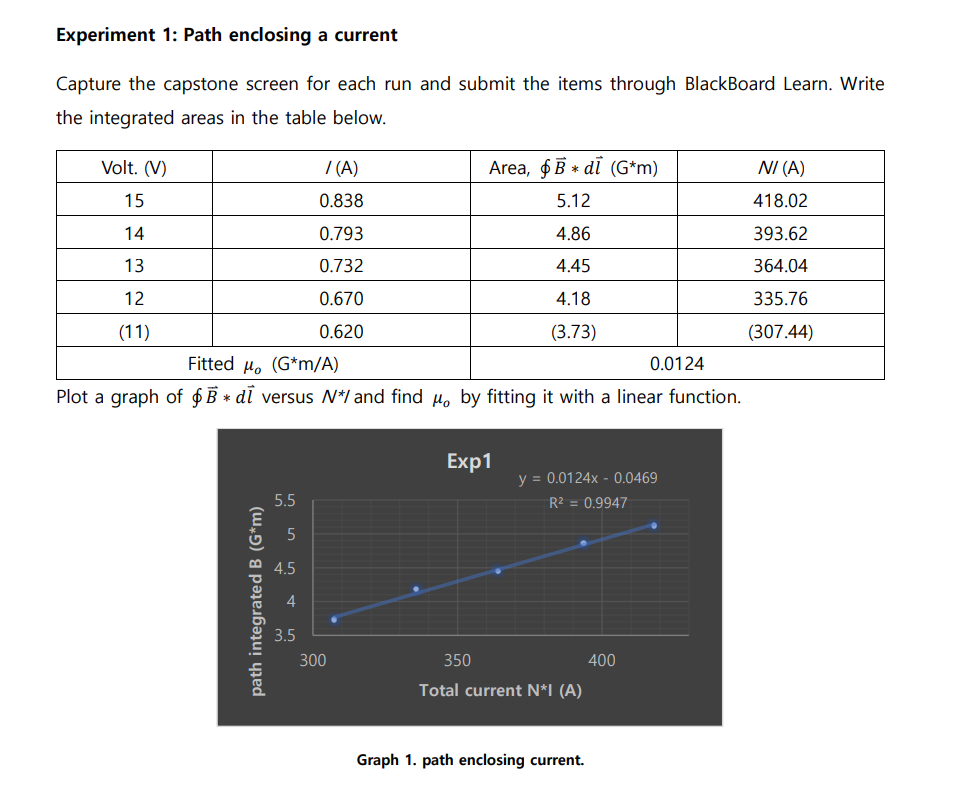

*Refer to https://docs.google.com/spreadsheets/d/1fd1RoHTrA-LQs3Di2oDhoObfbsI2rEpM/edit?usp=drive_link&ouid=107840157351743673732&rtpof=true&sd=true for more data and details of the curl and divergence data for different current and interpolation coefficient
